In [27]:
import pandas as pd
import numpy as np
import cv2
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, balanced_accuracy_score, ConfusionMatrixDisplay
import torch
from openface.face_detection import FaceDetector
from openface.landmark_detection import LandmarkDetector
from transformers import AutoImageProcessor, AutoModel 
from tqdm import tqdm
from openface.multitask_model import MultitaskPredictor
import torch.nn.functional as F
from typing import Union
from sklearn.preprocessing import StandardScaler

import numpy as np
import torch
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
    recall_score,
)
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from transformers import AutoImageProcessor, AutoModel


In [28]:
import logging
logging.disable(logging.DEBUG)

## Fix 

In [29]:
import imageio.v3 as iio
import zipfile
from IPython.display import Image, Video
from openface.face_detection import FaceDetector

# The next block fixes a bug that causes crashes on Unix-based systems.
# You should apply this patch before importing "LandmarkDetector" from openface.

# --- begin of patch ---
# Patching LandmarkDetector hardcoded log folder
from openface.STAR.demo import Alignment

# Access the utility module through Alignment.__init__'s globals
utility = Alignment.__init__.__globals__['utility']

# Only patch once to avoid recursion
if getattr(utility.set_environment, '__name__', '') != 'patched_set_environment':
    original_set_environment = utility.set_environment

    def patched_set_environment(config):
        result = original_set_environment(config)
        config.log_dir = '.'
        return result

    utility.set_environment = patched_set_environment
# --- end of patch ---

# The next patch overrides a function in FaceDetector which expects a filename as input to also accept numpy arrays
# This will be useful later when we want to pass webcam frames directly without saving to disk

# --- begin of patch ---
def override_preprocess_image(self, image_path: Union[str, np.ndarray], resize: float = 1.0):
    if isinstance(image_path, (str, os.PathLike)):
        img_raw = cv2.imread(str(image_path), cv2.IMREAD_COLOR)  # BGR, 3 channels
        if img_raw is None:
            raise ValueError(f"Failed to read image from path: {image_path}")
    elif isinstance(image_path, np.ndarray):
        img_raw = image_path
    else:
        raise TypeError("image_path must be a str/Path-like path or a numpy.ndarray (BGR frame).")

    if img_raw.ndim == 2:
        # Grayscale -> BGR
        img_raw = cv2.cvtColor(img_raw, cv2.COLOR_GRAY2BGR)
    elif img_raw.ndim == 3:
        if img_raw.shape[2] == 4:
            # BGRA -> BGR
            img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGRA2BGR)
        elif img_raw.shape[2] != 3:
            raise ValueError(f"Unsupported channel count: {img_raw.shape[2]} (expected 1, 3, or 4)")
    else:
        raise ValueError(f"Unsupported image shape {img_raw.shape}; expected HxW or HxWxC.")

    # --- Preprocess as in original code
    img = img_raw.astype(np.float32, copy=False)
    if resize != 1.0:
        img = cv2.resize(img, None, fx=resize, fy=resize, interpolation=cv2.INTER_LINEAR)

    # Mean subtraction in BGR (matching many Caffe-style models)
    img -= (104.0, 117.0, 123.0)

    # Ensure contiguous before transpose (safer with slices or unusual strides)
    img = np.ascontiguousarray(img.transpose(2, 0, 1))  # (C, H, W)

    img = torch.from_numpy(img).unsqueeze(0).to(self.device)  # (1, C, H, W)

    return img, img_raw

FaceDetector.preprocess_image = override_preprocess_image
# --- end of patch ---

## Split Data

In [30]:
import os
from collections import defaultdict

base_path = "DiffusionFER/DiffusionEmotion_S/cropped/cropped_extracted"

emotion_map = {
    "sad": "Nervous",
    "fear": "Nervous",
    "happy": "Confident",
    "neutral": "Neutral",
    "angry": "Defensive",
    "disgust": "Defensive",
    "contempt": "Defensive",
    "surprise": "Neutral"
}

new_classes = ["Confident", "Nervous", "Neutral", "Defensive"]

csv_path = "DiffusionFER/DiffusionEmotion_S/dataset_sheet.csv"
df = pd.read_csv(csv_path)

df["raw_emotion"] = df["subDirectory_filePath"].apply(lambda p: p.split("/")[1])
df["filename"] = df["subDirectory_filePath"].apply(lambda p: p.split("/")[2])

base_real_path = "DiffusionFER/DiffusionEmotion_S/cropped/cropped_extracted"

df["real_path"] = df.apply(
    lambda row: os.path.join(base_real_path, row["raw_emotion"], row["filename"]),
    axis=1
)

df = df[df["real_path"].apply(os.path.exists)].reset_index(drop=True)

df["valence"] = df["valence"].astype(float)
df["arousal"] = df["arousal"].astype(float)

df["mapped_emotion"] = df["raw_emotion"].map(emotion_map)

In [31]:
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["mapped_emotion"],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["mapped_emotion"],
    random_state=42
)

def print_stats(name, split_df):
    print(f"\n===== {name.upper()} SET =====")

    # Class distribution
    total = len(split_df)
    print("\nClass distribution:")
    for cls in new_classes:
        c = (split_df["mapped_emotion"] == cls).sum()
        print(f"{cls:10s}: {c} ({c/total*100:.1f}%)")

    # Overall valence/arousal
    print("\nValence stats:")
    print(split_df["valence"].describe())

    print("\nArousal stats:")
    print(split_df["arousal"].describe())

    print("\n--- PER CLASS STATS ---")
    for cls in new_classes:
        subset = split_df[split_df["mapped_emotion"] == cls]
        print(f"\n{cls} (n={len(subset)})")
        print("Valence:")
        print(subset["valence"].describe())
        print("Arousal:")
        print(subset["arousal"].describe())



In [32]:
print_stats("train", train_df)
print_stats("val", val_df)
print_stats("test", test_df)


===== TRAIN SET =====

Class distribution:
Confident : 238 (26.4%)
Nervous   : 107 (11.9%)
Neutral   : 371 (41.1%)
Defensive : 186 (20.6%)

Valence stats:
count    902.000000
mean      -0.038248
std        0.344660
min       -1.000000
25%       -0.300000
50%        0.000000
75%        0.300000
max        0.700000
Name: valence, dtype: float64

Arousal stats:
count    902.000000
mean       0.225166
std        0.257234
min       -0.300000
25%        0.000000
50%        0.200000
75%        0.400000
max        1.000000
Name: arousal, dtype: float64

--- PER CLASS STATS ---

Confident (n=238)
Valence:
count    238.000000
mean       0.407983
std        0.098829
min        0.000000
25%        0.400000
50%        0.400000
75%        0.500000
max        0.700000
Name: valence, dtype: float64
Arousal:
count    238.000000
mean       0.273529
std        0.147886
min        0.000000
25%        0.100000
50%        0.300000
75%        0.400000
max        0.700000
Name: arousal, dtype: float64

Nervo

## First Methodology: Geometric facial landmarks features with simple classifiers 

This methodology extracts facial landmark features from each image using the OpenFace framework. Each face is detected with RetinaFace, and 98 facial landmarks are extracted and flattened into feature vectors.

In [ ]:
device = "cpu"

# Initialize face detector using RetinaFace model for detecting faces in images
det = FaceDetector(model_path="./weights/Alignment_RetinaFace.pth", device=device)

# Initialize landmark detector for extracting 98 facial landmark points
lmk = LandmarkDetector("./weights/Landmark_98.pkl", device=device)

def detect_face_and_get_landmarks(image):
    """Detect face and extract 98 landmarks from a PIL image."""
    # Convert PIL image (RGB) to OpenCV format (BGR)
    img_bgr = cv2.cvtColor(np.array(image.convert("RGB")), cv2.COLOR_RGB2BGR)

    # Detect faces in the image, returns bounding box coordinates
    _, dets = det.get_face(img_bgr)
    # If no face detected, save debug image and return None
    if dets is None or len(dets) == 0:
        image.save("no_face_detected.png")
        return None
    pts = lmk.detect_landmarks(img_bgr, [dets[0]])[0].astype(np.float32)  # (98, 2)
    return pts

2025-12-16 10:05:00,994 INFO    : Loaded configure file alignment: 1b039e1c-7f49-479f-be49-4b6b38a5ae42
2025-12-16 10:05:00,994 INFO    : Loaded configure file alignment: 1b039e1c-7f49-479f-be49-4b6b38a5ae42
2025-12-16 10:05:00,995 INFO    : 
type: alignment
id: 1b039e1c-7f49-479f-be49-4b6b38a5ae42
note: 
ckpt_dir: /work/jiewenh/openFace/OpenFace-3.0/STAR
image_dir: ./WFLW/WFLW_images
annot_dir: ./
loader_type: alignment
loss_func: STARLoss_v2
batch_size: 32
val_batch_size: 32
test_batch_size: 16
channels: 3
width: 256
height: 256
means: (127.5, 127.5, 127.5)
scale: 0.00784313725490196
display_iteration: 10
milestones: [200, 350, 450]
max_epoch: 500
net: stackedHGnet_v1
nstack: 4
optimizer: adam
learn_rate: 0.001
momentum: 0.01
weight_decay: 1e-05
nesterov: False
scheduler: MultiStepLR
gamma: 0.1
loss_weights: [0.125, 1.25, 1.25, 0.25, 2.5, 2.5, 0.5, 5.0, 5.0, 1.0, 10.0, 10.0]
criterions: ['STARLoss_v2', 'AWingLoss', 'AWingLoss', 'STARLoss_v2', 'AWingLoss', 'AWingLoss', 'STARLoss_v2', 

Loading pretrained model from ./weights/Alignment_RetinaFace.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:300
Namespace(config_name='alignment', device_id='cpu')


The `extract_landmark_features` processes a batch of images to extract facial landmark features. For each image, it detects the face and extracts 98 landmark points, then flattens them into a 196-dimensional feature vector. Images where no face is detected are skipped and only valid image-label pairs are returned.


In [ ]:
from contextlib import redirect_stdout

def extract_landmark_features(images, labels):
    """Extract facial landmarks as features from a list of images."""
    features = []      # Store extracted landmark features
    valid_labels = []  # Store labels only for images where face was detected
    skipped = 0        # Counter for images without detected faces

    # Redirect stdout to suppress verbose output
    with open(os.devnull, 'w') as devnull:
        with redirect_stdout(devnull):
            # Process each image in the dataset
            for index, img in enumerate(images):
                # Detect face and extract 98 facial landmark points
                pts = detect_face_and_get_landmarks(img)
                
                # Skip images where no face could be detected
                if pts is None:
                    skipped += 1
                    continue
                
                # Flatten 98 landmarks (x,y coordinates) into 1D vector of 196 values
                feature_vector = pts.flatten()  # shape: (98, 2) -> (196,)
                features.append(feature_vector)
                
                # Keep corresponding label for this image
                valid_labels.append(labels[index])
    
    print(f"Skipped {skipped} images (no face detected)")
    
    return np.array(features), np.array(valid_labels)

A dictionary was created to map emotion names (Confident, Nervous, Neutral) to numeric indices for model training. The `load_images_from_df` function reads images from file paths in the DataFrame, converts them to RGB format, and pairs them with their corresponding numeric labels. All images were then loaded for the train, validation, and test splits.


In [ ]:
from PIL import Image

# Get unique emotion classes from the training data
new_classes = train_df["mapped_emotion"].unique().tolist()

# Create a dictionary mapping emotion names to numeric indices 
emotion_to_idx = {emo: idx for idx, emo in enumerate(new_classes)}
print(f"Classes: {emotion_to_idx}")

def load_images_from_df(df):
    """
    Load images and numeric labels from a DataFrame.
    
    Args:
        df: DataFrame with 'real_path' (image file paths) and 'mapped_emotion' columns
    
    Returns:
        images: List of PIL Image objects in RGB format
        labels: List of numeric labels corresponding to emotion classes
    """
    images = []
    labels = []
    
    # Iterate through each row in the DataFrame
    for _, row in df.iterrows():
        img_path = row["real_path"]
        # Load image and convert to RGB
        img = Image.open(img_path).convert('RGB')
        images.append(img)
        # Convert emotion string to numeric index
        labels.append(emotion_to_idx[row["mapped_emotion"]])
    
    return images, labels

# Load images for each split (train, validation, test)
print("Loading training images...")
train_images, train_labels = load_images_from_df(train_df)

print("Loading validation images...")
val_images, val_labels = load_images_from_df(val_df)

print("Loading test images...")
test_images, test_labels = load_images_from_df(test_df)

print(f"\nTrain: {len(train_images)} images")
print(f"Val: {len(val_images)} images")
print(f"Test: {len(test_images)} images")

Classes: {'Nervous': 0, 'Defensive': 1, 'Confident': 2, 'Neutral': 3}
Loading training images...
Loading validation images...
Loading test images...

Train: 902 images
Val: 193 images
Test: 194 images


Landmark extraction was performed on all splits, generating 196-dimensional feature vectors for training, validation, and testing.

In [40]:
import time

print("\nExtracting Training Landmark Features")
t0 = time.time()
train_features_lmk, train_labels_lmk = extract_landmark_features(train_images, train_labels)
print(f"Training landmark extraction time: {time.time() - t0:.2f} seconds")

print("\nExtracting Validation Landmark Features")
t0 = time.time()
val_features_lmk, val_labels_lmk = extract_landmark_features(val_images, val_labels)
print(f"Validation landmark extraction time: {time.time() - t0:.2f} seconds")

print("\nExtracting Test Landmark Features")
t0 = time.time()
test_features_lmk, test_labels_lmk = extract_landmark_features(test_images, test_labels)
print(f"Test landmark extraction time: {time.time() - t0:.2f} seconds")

print(f"\nTrain features shape: {train_features_lmk.shape}")
print(f"Val features shape: {val_features_lmk.shape}")
print(f"Test features shape: {test_features_lmk.shape}")


Extracting Training Landmark Features
Skipped 4 images (no face detected)
Training landmark extraction time: 126.96 seconds

Extracting Validation Landmark Features
Skipped 0 images (no face detected)
Validation landmark extraction time: 30.25 seconds

Extracting Test Landmark Features
Skipped 0 images (no face detected)
Test landmark extraction time: 29.29 seconds

Train features shape: (898, 196)
Val features shape: (193, 196)
Test features shape: (194, 196)


### SVM Training with Grid Search

A Support Vector Machine (SVM) classifier was trained on the extracted facial landmark features. The pipeline included feature standardization followed by an RBF kernel SVM. GridSearchCV with 10-fold stratified cross-validation was used to find optimal hyperparameters (C, gamma, class_weight), optimizing for macro F1-score. 


Fitting 10 folds for each of 84 candidates, totalling 840 fits
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.1s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.1s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.1s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.1s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.1s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.1s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.1s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.1s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.1s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.1s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=0.001; total time=   0.1s
[CV] END svm__C=0.1, svm__class_wei

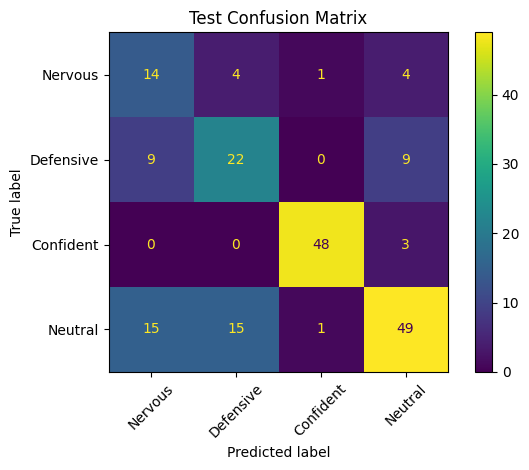

In [ ]:
import numpy as np
import torch
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt

# Import evaluation metrics from scikit-learn
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
    recall_score,
)
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from transformers import AutoImageProcessor, AutoModel

# Set random seeds for reproducibility across numpy, PyTorch CPU and GPU
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Create class-to-index mapping for emotion labels
class_to_idx = {cls: i for i, cls in enumerate(new_classes)}
num_classes = len(new_classes)

def plot_cm(y_true, y_pred, title):
    """
    Plot and display a confusion matrix.
    
    Args:
        y_true: Ground truth labels
        y_pred: Predicted labels
        title: Title for the plot
    
    Returns:
        cm: The confusion matrix array
    """
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    disp = ConfusionMatrixDisplay(cm, display_labels=new_classes)
    disp.plot(xticks_rotation=45)
    plt.title(title)
    plt.tight_layout()
    plt.show()
    return cm


svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),  # Normalize features to zero mean and unit variance
    ("svm", SVC(kernel="rbf"))    
])

param_grid = {
    "svm__C": [0.1, 1, 3, 5, 7, 9, 10],                          
    "svm__gamma": ["scale", 1e-3, 3e-3, 1e-2, 3e-2, 1e-1],       
    "svm__class_weight": [None, "balanced"],                     
}

# 10-fold stratified cross-validation (maintains class distribution in each fold)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

# Configure grid search with macro F1-score as optimization metric
grid = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid,
    scoring="f1_macro",   
    cv=cv,
    n_jobs=-1,           
    verbose=2
)

start_time_svm = time.time()
grid.fit(train_features_lmk, train_labels_lmk)
train_time_svm = time.time() - start_time_svm

print("\nBest params:", grid.best_params_)
print("Best CV macro-F1:", grid.best_score_)

# Get the best model
best_svm = grid.best_estimator_

# Evaluate on validation set
y_val_pred_svm = best_svm.predict(val_features_lmk)
f1_val_svm = f1_score(val_labels_lmk, y_val_pred_svm, average="macro")
print(f"\nVal F1: {f1_val_svm:.4f}")

# Evaluate on test set
y_test_pred_svm = best_svm.predict(test_features_lmk)
f1_test_svm = f1_score(test_labels_lmk, y_test_pred_svm, average="macro")
recall_test_svm = recall_score(test_labels_lmk, y_test_pred_svm, average="macro")
print(f"\nTest F1: {f1_test_svm:.4f}, "
    f"\nTest Recall: {recall_test_svm:.4f}, "
    f"\nTrain+CV time: {train_time_svm:.3f}s"
)

print("\nTest Report")
print(classification_report(test_labels_lmk, y_test_pred_svm, target_names=new_classes))

cm_test_svm = plot_cm(test_labels_lmk, y_test_pred_svm, "Test Confusion Matrix")


### SVM Training with Validation set

The landmark features were normalized using StandardScaler to ensure zero mean and unit variance. The scaler was fit on the training data and then applied to transform the validation and test sets.

In [ ]:
# Normalize features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features_lmk)
val_features_scaled = scaler.transform(val_features_lmk)
test_features_scaled = scaler.transform(test_features_lmk)

Hyperparameter tuning was performed to find the best configuration of the parameters C, gamma, and kernel. Each model was trained using balanced class weights to address class imbalance and evaluated on the validation set using the macro F1-score.

In [46]:
# Hyper-parameter tuning
param_combinations = [
    {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'},
    {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'},
    {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'},
    {'C': 100.0, 'gamma': 'scale', 'kernel': 'rbf'},
    {'C': 1.0, 'gamma': 'auto', 'kernel': 'rbf'},
    {'C': 10.0, 'gamma': 'auto', 'kernel': 'rbf'},
    {'C': 1.0, 'kernel': 'linear'},
    {'C': 10.0, 'kernel': 'linear'},
]

best_f1 = 0
best_params = None
best_model = None

for params in param_combinations:
    # Train model
    start_time = time.time()
    svm = SVC(class_weight='balanced', random_state=42, **params)
    svm.fit(train_features_scaled, train_labels_lmk)
    training_time = time.time() - start_time 
    # Evaluate on validation set
    val_preds = svm.predict(val_features_scaled)
    val_f1 = f1_score(val_labels_lmk, val_preds, average='macro')
    
    print(f"Params: {params}")
    print(f"  Val F1-macro: {val_f1*100:.2f}%\n")
    print(f"  Training time: {training_time:.2f} seconds\n")
    
    # Track best model
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_params = params
        best_model = svm

print(f"\nBest parameters: {best_params}")
print(f"\nBest validation F1-macro: {best_f1*100:.2f}%")


Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
  Val F1-macro: 40.05%

  Training time: 0.06 seconds

Params: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
  Val F1-macro: 54.72%

  Training time: 0.04 seconds

Params: {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}
  Val F1-macro: 62.79%

  Training time: 0.04 seconds

Params: {'C': 100.0, 'gamma': 'scale', 'kernel': 'rbf'}
  Val F1-macro: 65.79%

  Training time: 0.05 seconds

Params: {'C': 1.0, 'gamma': 'auto', 'kernel': 'rbf'}
  Val F1-macro: 54.72%

  Training time: 0.04 seconds

Params: {'C': 10.0, 'gamma': 'auto', 'kernel': 'rbf'}
  Val F1-macro: 62.79%

  Training time: 0.04 seconds

Params: {'C': 1.0, 'kernel': 'linear'}
  Val F1-macro: 77.64%

  Training time: 0.10 seconds

Params: {'C': 10.0, 'kernel': 'linear'}
  Val F1-macro: 74.74%

  Training time: 0.52 seconds


Best parameters: {'C': 1.0, 'kernel': 'linear'}

Best validation F1-macro: 77.64%


Test F1-Score (macro): 69.12%
Inference time on test set: 0.01 seconds

Test Classification Report:
              precision    recall  f1-score   support

     Nervous       0.98      0.92      0.95        51
   Defensive       0.61      0.55      0.58        40
   Confident       0.38      0.65      0.48        23
     Neutral       0.81      0.71      0.76        80

    accuracy                           0.73       194
   macro avg       0.69      0.71      0.69       194
weighted avg       0.76      0.73      0.74       194


Test Confusion Matrix:
[[15  4  0  4]
 [12 22  0  6]
 [ 0  1 47  3]
 [13  9  1 57]]


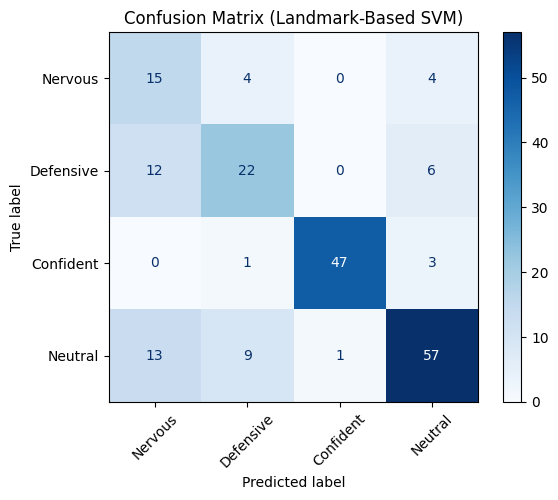

In [47]:
new_classes = ['Nervous', 'Defensive', 'Confident', 'Neutral']

start_time = time.time()
test_preds_lmk = best_model.predict(test_features_scaled)
inference_time = time.time() - start_time

test_f1_macro = f1_score(test_labels_lmk, test_preds_lmk, average='macro')

print(f"Test F1-Score (macro): {test_f1_macro*100:.2f}%")
print(f"Inference time on test set: {inference_time:.2f} seconds")

print("\nTest Classification Report:")
test_labels_lmk_names = [new_classes[lbl] for lbl in test_labels_lmk]
test_preds_lmk_names = [new_classes[pred] for pred in test_preds_lmk]
print(classification_report(test_labels_lmk_names, test_preds_lmk_names, target_names=new_classes))

print("\nTest Confusion Matrix:")
cm_lmk = confusion_matrix(test_labels_lmk, test_preds_lmk)
print(cm_lmk)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_lmk, display_labels=new_classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (Landmark-Based SVM)")
plt.show()

## Second Methodology: DINOv2 deep learning features with SVM classifier

The pretrained DINOv2-large model from Facebook was loaded to extract deep visual features from images. The `extract_dino_features` function processes each image through the model and extracts the CLS token embedding (pooled output), which captures global image information. Features were extracted for all splits.


In [ ]:
from transformers import AutoImageProcessor, AutoModel

# Load the pretrained DINOv2 model and image processor from Hugging Face
pretrained_model_name = "facebook/dinov2-large"
processor = AutoImageProcessor.from_pretrained(pretrained_model_name)  
dino_model = AutoModel.from_pretrained(pretrained_model_name)          

# Set model to evaluation mode 
dino_model.eval()

@torch.inference_mode()  # Disable gradient computation 
def extract_dino_features(images):
    """
    Extract DINOv2 CLS token features from a list of images.
    
    The CLS token is a global representation of the entire image,
    commonly used for classification tasks.
    
    Args:
        images: List of PIL Image objects
    
    Returns:
        Tensor of shape (n_images, feature_dim) containing CLS token embeddings
    """
    feats = []
    for image in images:
        # Preprocess image (resize, normalize, convert to tensor)
        inputs = processor(images=[image], return_tensors="pt")
        # Forward pass through DINOv2
        outputs = dino_model(**inputs)
        # Extract pooled CLS token output and move to CPU
        pooled = outputs.pooler_output.detach().cpu()  # Shape: (1, 1024) 
        feats.append(pooled)
    # Concatenate all features into single tensor
    return torch.cat(feats, dim=0)


# Extract features for training set
print("\nExtracting Training DINOv2 Features")
t0 = time.time()
train_features_dino = extract_dino_features(train_images)
print(f"Time: {time.time() - t0:.2f} seconds")

# Extract features for validation set
print("\nExtracting Validation DINOv2 Features")
t0 = time.time()
val_features_dino = extract_dino_features(val_images)
print(f"Time: {time.time() - t0:.2f} seconds")

# Extract features for test set
print("\nExtracting Test DINOv2 Features")
t0 = time.time()
test_features_dino = extract_dino_features(test_images)
print(f"Time: {time.time() - t0:.2f} seconds")

print(f"\nTrain features shape: {train_features_dino.shape}")
print(f"\nVal features shape: {val_features_dino.shape}")
print(f"\nTest features shape: {test_features_dino.shape}")

train_features_dino = train_features_dino.numpy()
val_features_dino = val_features_dino.numpy()
test_features_dino = test_features_dino.numpy()


Extracting Training DINOv2 Features
Time: 286.04 seconds

Extracting Validation DINOv2 Features
Time: 59.04 seconds

Extracting Test DINOv2 Features
Time: 59.99 seconds

Train features shape: torch.Size([902, 1024])

Val features shape: torch.Size([193, 1024])

Test features shape: torch.Size([194, 1024])


### SVM Classifier Training with Grid Search

An SVM classifier was trained on the DINOv2 features using GridSearchCV with 10-fold stratified cross-validation. The pipeline includes StandardScaler for feature normalization followed by an RBF kernel SVM. After identifying the best parameters, the model was evaluated on validation and test sets.


Fitting 10 folds for each of 84 candidates, totalling 840 fits
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.4s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.4s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.4s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.4s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.4s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.4s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.5s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.5s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.4s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=0.001; total time=   0.4s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=0.001; total time=   0.4s
[CV] END svm__C=0.1, svm__class_wei

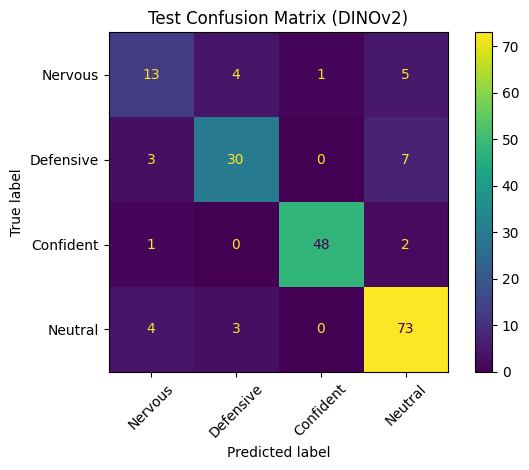

In [54]:
svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf"))
])

param_grid = {
    "svm__C": [0.1, 1, 3, 5, 7, 9, 10],
    "svm__gamma": ["scale", 1e-3, 3e-3, 1e-2, 3e-2, 1e-1],
    "svm__class_weight": [None, "balanced"],
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

grid = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2
)

start_time_svm = time.time()
grid.fit(train_features_dino, train_labels)  
train_time_svm = time.time() - start_time_svm

print("\nBest params:", grid.best_params_)
print("Best CV macro-F1:", grid.best_score_)

best_svm_dino = grid.best_estimator_

y_val_pred_svm = best_svm_dino.predict(val_features_dino) 
f1_val_svm = f1_score(val_labels, y_val_pred_svm, average="macro")
print(f"\nVal F1: {f1_val_svm:.4f}")

y_test_pred_svm = best_svm_dino.predict(test_features_dino)  
f1_test_svm = f1_score(test_labels, y_test_pred_svm, average="macro")
recall_test_svm = recall_score(test_labels, y_test_pred_svm, average="macro")
print(f"\nTest F1: {f1_test_svm:.4f}, "
    f"\nTest Recall: {recall_test_svm:.4f}, "
    f"\nTrain+CV time: {train_time_svm:.3f}s"
)
print("\nTest Report")
print(classification_report(test_labels, y_test_pred_svm, target_names=new_classes))
cm_test_svm = plot_cm(test_labels, y_test_pred_svm, "Test Confusion Matrix (DINOv2)")


### SVM Classifier Training with validation set

In [52]:
# Normalize features
scaler_dino = StandardScaler()
train_features_dino_scaled = scaler_dino.fit_transform(train_features_dino)
val_features_dino_scaled = scaler_dino.transform(val_features_dino)
test_features_dino_scaled = scaler_dino.transform(test_features_dino)

param_combinations = [
    {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'},
    {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'},
    {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'},
    {'C': 100.0, 'gamma': 'scale', 'kernel': 'rbf'},
    {'C': 1.0, 'gamma': 'auto', 'kernel': 'rbf'},
    {'C': 10.0, 'gamma': 'auto', 'kernel': 'rbf'},
    {'C': 1.0, 'kernel': 'linear'},
    {'C': 10.0, 'kernel': 'linear'},
]

best_f1_dino = 0
best_params_dino = None
best_model_dino = None

for params in param_combinations:
    # Train model
    svm = SVC(class_weight='balanced', random_state=42, **params)
    svm.fit(train_features_dino_scaled, train_labels)
    
    # Evaluate on validation set
    val_preds = svm.predict(val_features_dino_scaled)
    val_f1 = f1_score(val_labels, val_preds, average='macro')
    
    print(f"Params: {params}")
    print(f"  Val F1-macro: {val_f1*100:.2f}%\n")
    
    # Track best model
    if val_f1 > best_f1_dino:
        best_f1_dino = val_f1
        best_params_dino = params
        best_model_dino = svm

print(f"\nBest parameters: {best_params_dino}")
print(f"\nBest validation F1-macro: {best_f1_dino*100:.2f}%")

Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
  Val F1-macro: 60.19%

Params: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
  Val F1-macro: 82.20%

Params: {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}
  Val F1-macro: 89.91%

Params: {'C': 100.0, 'gamma': 'scale', 'kernel': 'rbf'}
  Val F1-macro: 89.91%

Params: {'C': 1.0, 'gamma': 'auto', 'kernel': 'rbf'}
  Val F1-macro: 82.20%

Params: {'C': 10.0, 'gamma': 'auto', 'kernel': 'rbf'}
  Val F1-macro: 89.91%

Params: {'C': 1.0, 'kernel': 'linear'}
  Val F1-macro: 79.53%

Params: {'C': 10.0, 'kernel': 'linear'}
  Val F1-macro: 79.53%


Best parameters: {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}

Best validation F1-macro: 89.91%


Test F1-Score (macro): 76.98%

Test Classification Report:
              precision    recall  f1-score   support

     Nervous       0.98      0.94      0.96        51
   Defensive       0.82      0.68      0.74        40
   Confident       0.58      0.48      0.52        23
     Neutral       0.80      0.93      0.86        80

    accuracy                           0.82       194
   macro avg       0.79      0.75      0.77       194
weighted avg       0.82      0.82      0.82       194


Test Confusion Matrix:
[[11  4  1  7]
 [ 3 27  0 10]
 [ 1  0 48  2]
 [ 4  2  0 74]]


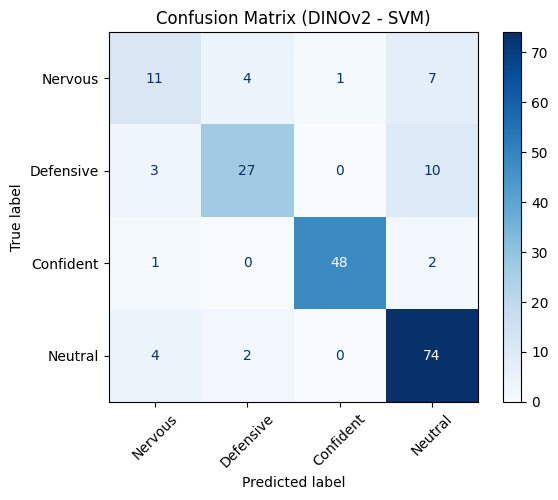

In [ ]:
test_preds_dino = best_model_dino.predict(test_features_dino_scaled)

test_f1_macro_dino = f1_score(test_labels, test_preds_dino, average='macro')
print(f"Test F1-Score (macro): {test_f1_macro_dino*100:.2f}%")

print("\nTest Classification Report:")
test_labels_dino_names = [new_classes[lbl] for lbl in test_labels]
test_preds_dino_names = [new_classes[pred] for pred in test_preds_dino]
print(classification_report(test_labels_dino_names, test_preds_dino_names, target_names=new_classes))

print("\nTest Confusion Matrix:")
cm_dino = confusion_matrix(test_labels, test_preds_dino)
print(cm_dino)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_dino, display_labels=new_classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (DINOv2 - SVM)")
plt.show()

## Third Methodology: DL Models Pre-trained for Emotion Recognition

### trpakov/vit-face-expression

A pre-trained Vision Transformer (ViT) model specifically fine-tuned for facial expression recognition (trpakov/vit-face-expression) was loaded from Hugging Face. The model was set to evaluation mode. The model's original 7-class emotion predictions were mapped to our 4-class scheme (Nervous, Defensive, Confident, Neutral). Performance was evaluated on the test set.

Model's label mapping:
{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


ViT predictions: 100%|████████████████████████| 194/194 [00:15<00:00, 12.66it/s]

Test F1-Score (macro): 59.10%

Test Classification Report:
              precision    recall  f1-score   support

     Nervous       1.00      0.84      0.91        51
   Defensive       0.64      0.40      0.49        40
   Confident       0.40      0.17      0.24        23
     Neutral       0.60      0.88      0.71        80

    accuracy                           0.69       194
   macro avg       0.66      0.57      0.59       194
weighted avg       0.69      0.69      0.67       194


Test Confusion Matrix:
[[ 4  1  0 18]
 [ 4 16  0 20]
 [ 0  0 43  8]
 [ 2  8  0 70]]


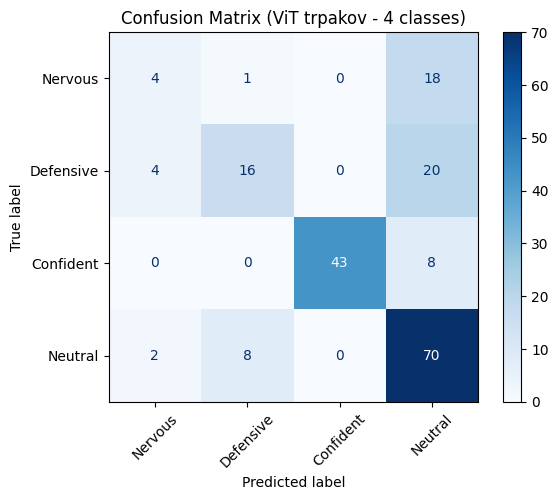

In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

# Load pre-trained ViT model and processor for facial expression recognition
processor_vit = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression")
model_vit = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")
model_vit.eval()  # Set model to evaluation mode 

print("Model's label mapping:")
print(model_vit.config.id2label)

preds_vit = []  

@torch.inference_mode()  
def predict_emotion_vit(image):
    """
    Predicts the emotion label for a single image using the ViT model.
    Returns the predicted emotion as a lowercase string.
    """
    inputs = processor_vit(images=image, return_tensors="pt")  # Preprocess image for ViT
    outputs = model_vit(**inputs)  # Forward pass 
    logits = outputs.logits  # Get raw prediction scores
    predicted_class_idx = logits.argmax(-1).item()  # Get index of highest score
    predicted_label = model_vit.config.id2label[predicted_class_idx]  # Convert index to label
    return predicted_label.lower()

# Iterate through test images 
for image in tqdm(test_images, desc="ViT predictions", ncols=80):
    try:
        pred_emotion = predict_emotion_vit(image)  # Get 7-class emotion prediction
        # Map 7 emotions to 4 classes using existing emotion_map
        mapped_class = emotion_map[pred_emotion]
        preds_vit.append(emotion_to_idx[mapped_class])  # Store as numeric index
    except Exception as e:
        print(f"Error: {e}")
        preds_vit.append(emotion_to_idx['Neutral'])  # Default to Neutral on error

f1_macro_vit = f1_score(test_labels, preds_vit, average='macro')
print(f"Test F1-Score (macro): {f1_macro_vit*100:.2f}%")

print("\nTest Classification Report:")
test_labels_names = [new_classes[lbl] for lbl in test_labels]  # Convert indices to names
preds_vit_names = [new_classes[pred] for pred in preds_vit]
print(classification_report(test_labels_names, preds_vit_names, target_names=new_classes))

print("\nTest Confusion Matrix:")
cm_vit = confusion_matrix(test_labels, preds_vit)
print(cm_vit)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_vit, display_labels=new_classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (ViT trpakov - 4 classes)")
plt.show()


###  dima806/facial_emotions_image_detection 

A pre-trained model for facial emotion detection (dima806/facial_emotions_image_detection) was loaded from Hugging Face. This model outputs 7 emotion classes (sad, disgust, angry, neutral, fear, surprise, happy), which were mapped to the 4-class scheme: sad and fear → Nervous, disgust and angry → Defensive, neutral and surprise → Neutral, happy → Confident.

Model label mapping: {0: 'sad', 1: 'disgust', 2: 'angry', 3: 'neutral', 4: 'fear', 5: 'surprise', 6: 'happy'}


dima806 predictions: 100%|████████████████████| 194/194 [00:15<00:00, 12.79it/s]


Test F1-Score (macro): 55.17%

Test Classification Report:
              precision    recall  f1-score   support

     Nervous       0.87      0.94      0.91        51
   Defensive       0.62      0.20      0.30        40
   Confident       0.28      0.22      0.24        23
     Neutral       0.66      0.89      0.76        80

    accuracy                           0.68       194
   macro avg       0.61      0.56      0.55       194
weighted avg       0.66      0.68      0.64       194


Test Confusion Matrix:
[[ 5  3  1 14]
 [ 9  8  2 21]
 [ 1  0 48  2]
 [ 3  2  4 71]]


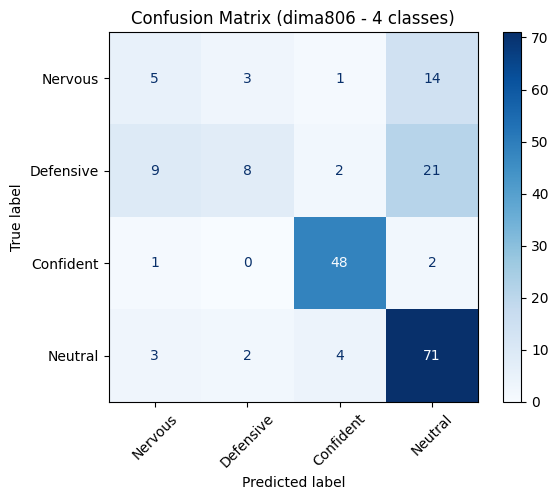

In [56]:
processor_dima = AutoImageProcessor.from_pretrained("dima806/facial_emotions_image_detection")
model_dima = AutoModelForImageClassification.from_pretrained("dima806/facial_emotions_image_detection")
model_dima.eval()

print(f"Model label mapping: {model_dima.config.id2label}")

# dima806 model outputs: {0: 'sad', 1: 'disgust', 2: 'angry', 3: 'neutral', 4: 'fear', 5: 'surprise', 6: 'happy'}
# Map dima806 predictions to your 4 classes
dima_to_mapped = {
    0: 'Nervous',    # sad → Nervous
    1: 'Defensive',  # disgust → Defensive
    2: 'Defensive',  # angry → Defensive
    3: 'Neutral',    # neutral → Neutral
    4: 'Nervous',    # fear → Nervous
    5: 'Neutral',    # surprise → Neutral
    6: 'Confident',  # happy → Confident
}

@torch.inference_mode()
def predict_emotion_dima(image):
    inputs = processor_dima(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model_dima(**inputs)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()
    return predicted_class_idx

preds_dima = []

for image in tqdm(test_images, desc="dima806 predictions", ncols=80):
    try:
        pred_idx = predict_emotion_dima(image)
        # Map to your 4 classes
        mapped_class = dima_to_mapped[pred_idx]
        preds_dima.append(emotion_to_idx[mapped_class])
    except Exception as e:
        print(f"Error: {e}")
        preds_dima.append(emotion_to_idx['Neutral'])

preds_dima = np.array(preds_dima)

# Evaluate with 4 classes
f1_macro_dima = f1_score(test_labels, preds_dima, average='macro')
print(f"\nTest F1-Score (macro): {f1_macro_dima*100:.2f}%")

print("\nTest Classification Report:")
test_labels_names = [new_classes[lbl] for lbl in test_labels]
preds_dima_names = [new_classes[pred] for pred in preds_dima]
print(classification_report(test_labels_names, preds_dima_names, target_names=new_classes))

print("\nTest Confusion Matrix:")
cm_dima = confusion_matrix(test_labels, preds_dima)
print(cm_dima)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_dima, display_labels=new_classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (dima806 - 4 classes)")
plt.show()

## Fourth Methodlogy - Patches - DINOV2

The pretrained DINOv2-large model from Facebook was loaded to extract deep visual features from images. Instead of using only the CLS token, the model’s patch-level embeddings were extracted and pooled using both average and max pooling. The pooled features were concatenated to form a single feature vector per image. Features were extracted for all splits.

In [57]:
from transformers import AutoImageProcessor, AutoModel
import torch
import numpy as np

# Load DINOv2
pretrained_model_name = "facebook/dinov2-large"
processor = AutoImageProcessor.from_pretrained(pretrained_model_name)
dino_model = AutoModel.from_pretrained(pretrained_model_name)
dino_model.eval()

@torch.inference_mode()
def extract_patch_features(images):
    """Extract per-patch features from DINOv2 (not just CLS token)"""
    all_features = []
    
    for image in tqdm(images, desc="Extracting patch features"):
        inputs = processor(images=[image], return_tensors="pt")
        outputs = dino_model(**inputs)
        
        # last_hidden_state shape: (1, 257, 1024) 
        # 257 = 1 CLS token + 256 patch tokens (16x16 grid for dinov2-large)
        patch_tokens = outputs.last_hidden_state[0, 1:, :]  # Skip CLS, get patches: (256, 1024)
        
        # Option 1: Average pooling over patches
        avg_pooled = patch_tokens.mean(dim=0)  # (1024,)
        
        # Option 2: Max pooling over patches
        max_pooled = patch_tokens.max(dim=0).values  # (1024,)
        
        # Option 3: Concatenate avg + max (richer features)
        combined = torch.cat([avg_pooled, max_pooled], dim=0)  # (2048,)
        
        # Option 4: Flatten all patches (very high-dim, may need PCA)
        # flattened = patch_tokens.flatten()  # (256*1024,) = (262144,)
        
        all_features.append(combined.cpu().numpy())
    
    return np.stack(all_features, axis=0)

# Extract features
print("\nExtracting Training Patch Features")
t0 = time.time()
train_features_patch = extract_patch_features(train_images)
print(f"Time: {time.time() - t0:.2f} seconds")

print("\nExtracting Validation Patch Features")
t0 = time.time()
val_features_patch = extract_patch_features(val_images)
print(f"Time: {time.time() - t0:.2f} seconds")

print("\nExtracting Test Patch Features")
t0 = time.time()
test_features_patch = extract_patch_features(test_images)
print(f"Time: {time.time() - t0:.2f} seconds")

print(f"\nTrain features shape: {train_features_patch.shape}")
print(f"Val features shape: {val_features_patch.shape}")
print(f"Test features shape: {test_features_patch.shape}")



Extracting Training Patch Features


Extracting patch features: 100%|██████████| 902/902 [04:40<00:00,  3.22it/s]


Time: 280.17 seconds

Extracting Validation Patch Features


Extracting patch features: 100%|██████████| 193/193 [00:56<00:00,  3.43it/s]


Time: 56.29 seconds

Extracting Test Patch Features


Extracting patch features: 100%|██████████| 194/194 [01:12<00:00,  2.69it/s]

Time: 72.11 seconds

Train features shape: (902, 2048)
Val features shape: (193, 2048)
Test features shape: (194, 2048)


### Validation set

Params: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
  Val F1-macro: 81.28%

Params: {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}
  Val F1-macro: 87.30%

Params: {'C': 100.0, 'gamma': 'scale', 'kernel': 'rbf'}
  Val F1-macro: 87.30%

Params: {'C': 1.0, 'kernel': 'linear'}
  Val F1-macro: 81.14%

Params: {'C': 10.0, 'kernel': 'linear'}
  Val F1-macro: 81.14%


Best parameters: {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}
Best validation F1-macro: 87.30%

Test F1-Score (macro): 82.68%

Classification Report:
              precision    recall  f1-score   support

     Nervous       0.67      0.61      0.64        23
   Defensive       0.91      0.75      0.82        40
   Confident       0.98      0.94      0.96        51
     Neutral       0.84      0.95      0.89        80

    accuracy                           0.87       194
   macro avg       0.85      0.81      0.83       194
weighted avg       0.87      0.87      0.86       194



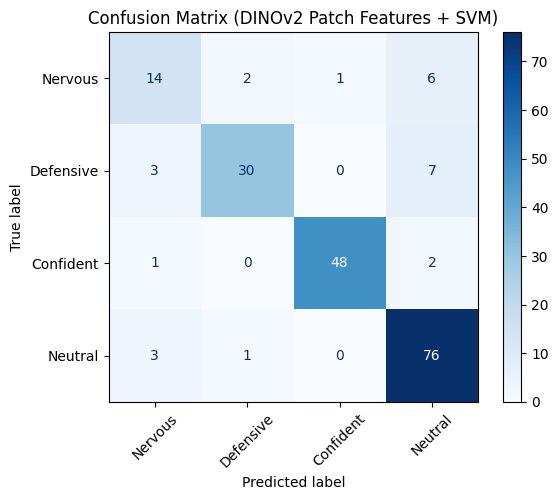

In [58]:
# Scale features
scaler_patch = StandardScaler()
train_features_patch_scaled = scaler_patch.fit_transform(train_features_patch)
val_features_patch_scaled = scaler_patch.transform(val_features_patch)
test_features_patch_scaled = scaler_patch.transform(test_features_patch)

# Hyperparameter tuning
param_combinations = [
    {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'},
    {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'},
    {'C': 100.0, 'gamma': 'scale', 'kernel': 'rbf'},
    {'C': 1.0, 'kernel': 'linear'},
    {'C': 10.0, 'kernel': 'linear'},
]

best_f1_patch = 0
best_params_patch = None
best_model_patch = None

for params in param_combinations:
    svm = SVC(class_weight='balanced', random_state=42, **params)
    svm.fit(train_features_patch_scaled, train_labels)
    
    val_preds = svm.predict(val_features_patch_scaled)
    val_f1 = f1_score(val_labels, val_preds, average='macro')
    
    print(f"Params: {params}")
    print(f"  Val F1-macro: {val_f1*100:.2f}%\n")
    
    if val_f1 > best_f1_patch:
        best_f1_patch = val_f1
        best_params_patch = params
        best_model_patch = svm

print(f"\nBest parameters: {best_params_patch}")
print(f"Best validation F1-macro: {best_f1_patch*100:.2f}%")

# Test evaluation
test_preds_patch = best_model_patch.predict(test_features_patch_scaled)
test_f1_patch = f1_score(test_labels, test_preds_patch, average='macro')
print(f"\nTest F1-Score (macro): {test_f1_patch*100:.2f}%")

print("\nClassification Report:")
print(classification_report(test_labels, test_preds_patch, target_names=new_classes))

cm_patch = confusion_matrix(test_labels, test_preds_patch)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_patch, display_labels=new_classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (DINOv2 Patch Features + SVM)")
plt.show()

### Cross Validation


Running Cross-Validation...
Fitting 10 folds for each of 84 candidates, totalling 840 fits
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   1.7s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   1.6s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   1.7s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   1.7s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   1.5s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   1.5s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   1.6s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   1.5s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   1.5s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   1.4s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=0.001; total time=   1.6s
[CV] E

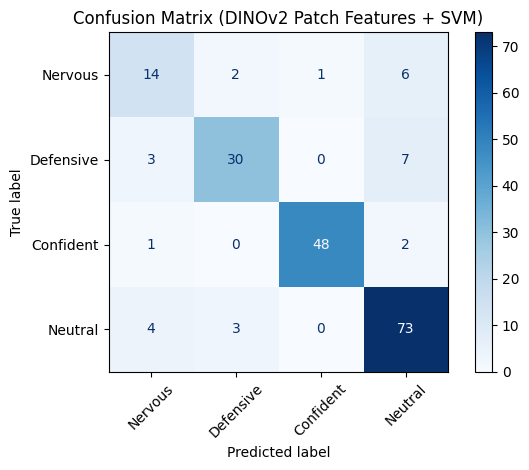

In [59]:
# Cross-validation with GridSearchCV
svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf"))
])

param_grid = {
    "svm__C": [0.1, 1, 3, 5, 7, 9, 10],
    "svm__gamma": ["scale", 1e-3, 3e-3, 1e-2, 3e-2, 1e-1],
    "svm__class_weight": [None, "balanced"],
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

grid = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2
)

print("\nRunning Cross-Validation...")
start_time = time.time()
grid.fit(train_features_patch, train_labels)
train_time = time.time() - start_time

print(f"\nBest params: {grid.best_params_}")
print(f"Best CV macro-F1: {grid.best_score_:.4f}")

best_svm_patch = grid.best_estimator_

# Validation set evaluation
y_val_pred = best_svm_patch.predict(val_features_patch)
f1_val = f1_score(val_labels, y_val_pred, average="macro")
print(f"\nVal F1: {f1_val:.4f}")

# Test set evaluation
y_test_pred = best_svm_patch.predict(test_features_patch)
f1_test = f1_score(test_labels, y_test_pred, average="macro")
recall_test = recall_score(test_labels, y_test_pred, average="macro")

print(f"\nTest F1: {f1_test:.4f}")
print(f"Test Recall: {recall_test:.4f}")
print(f"Train+CV time: {train_time:.3f}s")

print("\nTest Classification Report:")
print(classification_report(test_labels, y_test_pred, target_names=new_classes))

# Confusion Matrix
cm_patch = confusion_matrix(test_labels, y_test_pred)
disp = ConfusionMatrixDisplay(cm_patch, display_labels=new_classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (DINOv2 Patch Features + SVM)")
plt.tight_layout()
plt.show()

## Fifth Methodology - Patches - DINOV3

The pretrained DINOv3 ViT-S/16+ model was used to extract patch-level visual features from images. For each image, CLS and register tokens were discarded and only patch embeddings were retained. Average and max pooling were applied across patch tokens and concatenated to form a single feature vector per image. These features were used to train an RBF-kernel SVM, with hyperparameters selected via 10-fold stratified cross-validation. Performance was evaluated using macro F1 and recall on validation and test sets.


In [ ]:
# Load DINOv3 model
pretrained_model_name = "facebook/dinov3-vits16plus-pretrain-lvd1689m"
processor = AutoImageProcessor.from_pretrained(pretrained_model_name)
dino_model = AutoModel.from_pretrained(pretrained_model_name)
dino_model.to(device)
dino_model.eval()

print(f"Loaded: {pretrained_model_name}")

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 3e7ae171-491f-4045-8c30-037001d95391)')' thrown while requesting HEAD https://huggingface.co/facebook/dinov3-vits16plus-pretrain-lvd1689m/resolve/main/preprocessor_config.json
2025-12-16 11:15:50,096 WARNING : '(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 3e7ae171-491f-4045-8c30-037001d95391)')' thrown while requesting HEAD https://huggingface.co/facebook/dinov3-vits16plus-pretrain-lvd1689m/resolve/main/preprocessor_config.json
2025-12-16 11:15:50,096 WARNING : '(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 3e7ae171-491f-4045-8c30-037001d95391)')' thrown while requesting HEAD https://huggingface.co/facebook/dinov3-vits16plus-pretrain-lvd1689m/resolve/main/preprocessor_config.json
Retrying in 1s [Retry 1/5].
2025-12

Loaded: facebook/dinov3-vits16plus-pretrain-lvd1689m


In [61]:
@torch.inference_mode()
def extract_patch_pooled_features(images):
    """Extract patch features with avg+max pooling"""
    feats = []
    for image in tqdm(images, desc="Extracting patch pooled features"):
        inputs = processor(images=[image], return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = dino_model(**inputs)
        
        # DINOv3: 1 CLS + 4 registers + 196 patches = 201 tokens
        # Skip CLS and registers, get only patch tokens
        patch_tokens = outputs.last_hidden_state[0, 5:, :]  # (196, dim)
        
        avg_pooled = patch_tokens.mean(dim=0)
        max_pooled = patch_tokens.max(dim=0).values
        combined = torch.cat([avg_pooled, max_pooled], dim=0)  # (2*dim,)
        
        feats.append(combined.cpu().numpy())
    
    return np.stack(feats, axis=0)

In [62]:
# Extract features
print("\nExtracting Training Features...")
t0 = time.time()
train_features_patch = extract_patch_pooled_features(train_images)
print(f"Time: {time.time() - t0:.2f}s")

print("\nExtracting Validation Features...")
t0 = time.time()
val_features_patch = extract_patch_pooled_features(val_images)
print(f"Time: {time.time() - t0:.2f}s")

print("\nExtracting Test Features...")
t0 = time.time()
test_features_patch = extract_patch_pooled_features(test_images)
print(f"Time: {time.time() - t0:.2f}s")

print(f"\nFeature shapes:")
print(f"Train: {train_features_patch.shape}")
print(f"Val: {val_features_patch.shape}")
print(f"Test: {test_features_patch.shape}")



Extracting Training Features...


Extracting patch pooled features: 100%|██████████| 902/902 [00:26<00:00, 34.28it/s]


Time: 26.33s

Extracting Validation Features...


Extracting patch pooled features: 100%|██████████| 193/193 [00:05<00:00, 36.02it/s]


Time: 5.36s

Extracting Test Features...


Extracting patch pooled features: 100%|██████████| 194/194 [00:05<00:00, 35.64it/s]

Time: 5.45s

Feature shapes:
Train: (902, 768)
Val: (193, 768)
Test: (194, 768)



Running Cross-Validation...
Fitting 10 folds for each of 32 candidates, totalling 320 fits
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.3s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.3s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.3s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.3s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.3s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.3s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.3s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.3s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.3s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=0.001; total time=   0.3s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.3s
[CV] E

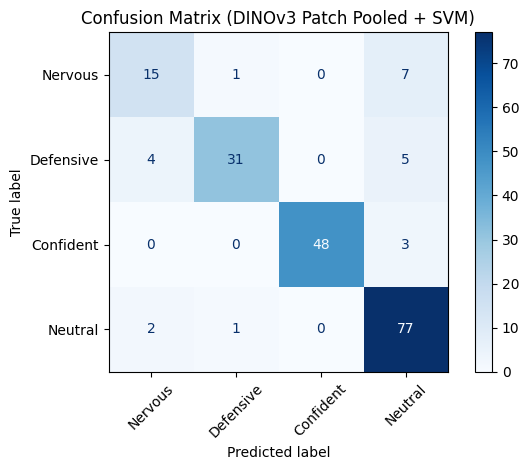

In [63]:
# Cross-validation
svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf"))
])

param_grid = {
    "svm__C": [0.1, 1, 5, 10],
    "svm__gamma": ["scale", 1e-3, 1e-2, 1e-1],
    "svm__class_weight": [None, "balanced"],
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2
)

print("\nRunning Cross-Validation...")
start_time = time.time()
grid.fit(train_features_patch, train_labels)
train_time = time.time() - start_time

print(f"\nBest params: {grid.best_params_}")
print(f"Best CV F1: {grid.best_score_:.4f}")

# Validation evaluation
val_pred = grid.best_estimator_.predict(val_features_patch)
val_f1 = f1_score(val_labels, val_pred, average="macro")
print(f"Val F1: {val_f1:.4f}")

# Test evaluation
test_pred = grid.best_estimator_.predict(test_features_patch)
test_f1 = f1_score(test_labels, test_pred, average="macro")
test_recall = recall_score(test_labels, test_pred, average="macro")

print(f"\nTest F1: {test_f1:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Training time: {train_time:.2f}s")

print("\nClassification Report:")
print(classification_report(test_labels, test_pred, target_names=new_classes))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=new_classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (DINOv3 Patch Pooled + SVM)")
plt.tight_layout()
plt.show()

## Sixth Methodology - Attention-Weighted Patch Features

The pretrained DINOv3 ViT-S/16+ model was used to extract patch-level embeddings from images. CLS and register tokens were removed, and patch features were aggregated using an attention-weighted pooling strategy based on the CLS token’s attention to patches (last layer, averaged across heads). The resulting attention-weighted vector was concatenated with max-pooled patch features to form a single representation per image (with average pooling as a fallback if attentions were unavailable). These features were classified using an RBF-kernel SVM with hyperparameters tuned via 10-fold stratified cross-validation, and evaluated using macro F1 and recall.








In [66]:
@torch.inference_mode()
def extract_attention_weighted_features(images):
    """Use attention to weight patch importance"""
    feats = []
    for image in tqdm(images, desc="Extracting attention-weighted features"):
        inputs = processor(images=[image], return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Try to get attentions
        try:
            outputs = dino_model(**inputs, output_attentions=True)
            
            # Get patch tokens (skip CLS and 4 registers)
            patch_tokens = outputs.last_hidden_state[0, 5:, :]  # (196, dim)
            
            # Check if attentions are available
            if outputs.attentions is not None:
                # Get attention from last layer, average across heads
                attn = outputs.attentions[-1][0].mean(dim=0)  # (num_tokens, num_tokens)
                
                # CLS token's attention to patches (indices 5+)
                cls_attn = attn[0, 5:]  # (196,)
                cls_attn = cls_attn / cls_attn.sum()  # Normalize
                
                # Weighted average
                weighted = (patch_tokens * cls_attn.unsqueeze(-1)).sum(dim=0)  # (dim,)
            else:
                # Fallback: just use average pooling
                weighted = patch_tokens.mean(dim=0)
            
            # Also include max pooling
            max_pooled = patch_tokens.max(dim=0).values  # (dim,)
            
            combined = torch.cat([weighted, max_pooled], dim=0)  # (2*dim,)
            feats.append(combined.cpu().numpy())
            
        except Exception as e:
            print(f"Error: {e}")
            # Fallback
            outputs = dino_model(**inputs)
            patch_tokens = outputs.last_hidden_state[0, 5:, :]
            avg_pooled = patch_tokens.mean(dim=0)
            max_pooled = patch_tokens.max(dim=0).values
            combined = torch.cat([avg_pooled, max_pooled], dim=0)
            feats.append(combined.cpu().numpy())
    
    return np.stack(feats, axis=0)


In [67]:
print("\nExtracting Training Features...")
t0 = time.time()
train_features_attn = extract_attention_weighted_features(train_images)
print(f"Time: {time.time() - t0:.2f}s")

print("\nExtracting Validation Features...")
t0 = time.time()
val_features_attn = extract_attention_weighted_features(val_images)
print(f"Time: {time.time() - t0:.2f}s")

print("\nExtracting Test Features...")
t0 = time.time()
test_features_attn = extract_attention_weighted_features(test_images)
print(f"Time: {time.time() - t0:.2f}s")

print(f"\nFeature shapes:")
print(f"Train: {train_features_attn.shape}")
print(f"Val: {val_features_attn.shape}")
print(f"Test: {test_features_attn.shape}")



Extracting Training Features...


Extracting attention-weighted features: 100%|██████████| 902/902 [00:26<00:00, 34.14it/s]


Time: 26.43s

Extracting Validation Features...


Extracting attention-weighted features: 100%|██████████| 193/193 [00:05<00:00, 34.98it/s]


Time: 5.52s

Extracting Test Features...


Extracting attention-weighted features: 100%|██████████| 194/194 [00:05<00:00, 33.89it/s]

Time: 5.73s

Feature shapes:
Train: (902, 768)
Val: (193, 768)
Test: (194, 768)



Running Cross-Validation...
Fitting 10 folds for each of 32 candidates, totalling 320 fits
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.3s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.3s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.3s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.2s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.3s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.3s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.3s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.3s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.2s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   0.2s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=0.001; total time=   0.3s
[CV] E

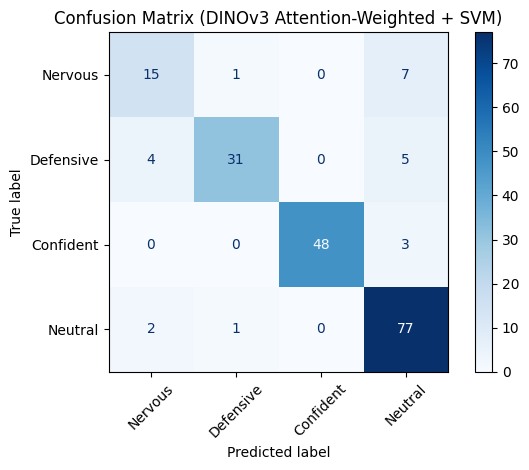

In [68]:
# Cross-validation
svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf"))
])

param_grid = {
    "svm__C": [0.1, 1, 5, 10],
    "svm__gamma": ["scale", 1e-3, 1e-2, 1e-1],
    "svm__class_weight": [None, "balanced"],
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2
)

print("\nRunning Cross-Validation...")
start_time = time.time()
grid.fit(train_features_attn, train_labels)
train_time = time.time() - start_time

print(f"\nBest params: {grid.best_params_}")
print(f"Best CV F1: {grid.best_score_:.4f}")

# Validation evaluation
val_pred = grid.best_estimator_.predict(val_features_attn)
val_f1 = f1_score(val_labels, val_pred, average="macro")
print(f"Val F1: {val_f1:.4f}")

# Test evaluation
test_pred = grid.best_estimator_.predict(test_features_attn)
test_f1 = f1_score(test_labels, test_pred, average="macro")
test_recall = recall_score(test_labels, test_pred, average="macro")

print(f"\nTest F1: {test_f1:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Training time: {train_time:.2f}s")

print("\nClassification Report:")
print(classification_report(test_labels, test_pred, target_names=new_classes))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=new_classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (DINOv3 Attention-Weighted + SVM)")
plt.tight_layout()
plt.show()

## Seveneth Methodology - Spatial Pyramid Pooling (Multi-Scale)

The pretrained DINOv3 ViT-S/16+ model was used to extract patch embeddings from images, discarding the CLS and register tokens. The 196 patch tokens were reshaped into a 14×14 grid and aggregated using Spatial Pyramid Pooling (SPP) by average pooling over multiple spatial levels (1×1 global, 2×2 quadrants, and a finer 7×7 partition). The pooled region vectors were concatenated into a single multi-scale representation per image. These features were classified using an RBF-kernel SVM with hyperparameters tuned via 10-fold stratified cross-validation, and evaluated using macro F1 and recall.

In [69]:
# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load DINOv3
pretrained_model_name = "facebook/dinov3-vits16plus-pretrain-lvd1689m"
processor = AutoImageProcessor.from_pretrained(pretrained_model_name)
dino_model = AutoModel.from_pretrained(pretrained_model_name)
dino_model.to(device)
dino_model.eval()
print(f"Loaded: {pretrained_model_name}")

# Feature extraction function
@torch.inference_mode()
def extract_spp_features(images):
    """Spatial Pyramid Pooling - capture multi-scale features"""
    feats = []
    for image in tqdm(images, desc="Extracting SPP features"):
        inputs = processor(images=[image], return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = dino_model(**inputs)
        
        # Get patch tokens and reshape to 14x14 grid
        patch_tokens = outputs.last_hidden_state[0, 5:, :]  # (196, dim)
        grid_size = 14  # sqrt(196) = 14
        dim = patch_tokens.shape[-1]
        patches_grid = patch_tokens.view(grid_size, grid_size, dim)  # (14, 14, dim)
        
        features = []
        
        # Level 1: Global (1x1) - whole face
        features.append(patches_grid.mean(dim=(0, 1)))  # (dim,)
        
        # Level 2: 2x2 quadrants
        h, w = grid_size // 2, grid_size // 2  # 7
        for i in range(2):
            for j in range(2):
                region = patches_grid[i*h:(i+1)*h, j*w:(j+1)*w, :]
                features.append(region.mean(dim=(0, 1)))  # (dim,)
        
        # Level 3: 7x7 regions (finer details)
        h, w = 2, 2
        for i in range(7):
            for j in range(7):
                i_start, i_end = i*2, min((i+1)*2, grid_size)
                j_start, j_end = j*2, min((j+1)*2, grid_size)
                region = patches_grid[i_start:i_end, j_start:j_end, :]
                features.append(region.mean(dim=(0, 1)))  # (dim,)
        
        # Total: 1 + 4 + 49 = 54 regions * dim
        combined = torch.cat(features, dim=0)
        feats.append(combined.cpu().numpy())
    
    return np.stack(feats, axis=0)

Using device: cpu
Loaded: facebook/dinov3-vits16plus-pretrain-lvd1689m


In [70]:
# Extract features
print("\nExtracting Training Features...")
t0 = time.time()
train_features_spp = extract_spp_features(train_images)
print(f"Time: {time.time() - t0:.2f}s")

print("\nExtracting Validation Features...")
t0 = time.time()
val_features_spp = extract_spp_features(val_images)
print(f"Time: {time.time() - t0:.2f}s")

print("\nExtracting Test Features...")
t0 = time.time()
test_features_spp = extract_spp_features(test_images)
print(f"Time: {time.time() - t0:.2f}s")

print(f"\nFeature shapes:")
print(f"Train: {train_features_spp.shape}")
print(f"Val: {val_features_spp.shape}")
print(f"Test: {test_features_spp.shape}")


Extracting Training Features...


Extracting SPP features: 100%|██████████| 902/902 [00:27<00:00, 32.91it/s]


Time: 27.43s

Extracting Validation Features...


Extracting SPP features: 100%|██████████| 193/193 [00:05<00:00, 32.18it/s]


Time: 6.00s

Extracting Test Features...


Extracting SPP features: 100%|██████████| 194/194 [00:06<00:00, 30.41it/s]

Time: 6.39s

Feature shapes:
Train: (902, 20736)
Val: (193, 20736)
Test: (194, 20736)



Running Cross-Validation...
Fitting 10 folds for each of 32 candidates, totalling 320 fits
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=  16.9s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=  16.9s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=  16.9s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=  17.0s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=  17.1s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=  17.1s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=  17.1s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=  17.2s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=  15.4s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=  15.5s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=0.001; total time=  19.9s
[CV] E

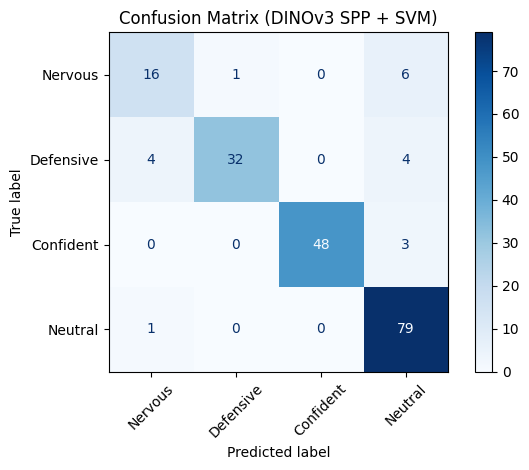

In [71]:
# Cross-validation
svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf"))
])

param_grid = {
    "svm__C": [0.1, 1, 5, 10],
    "svm__gamma": ["scale", 1e-3, 1e-2, 1e-1],
    "svm__class_weight": [None, "balanced"],
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2
)

print("\nRunning Cross-Validation...")
start_time = time.time()
grid.fit(train_features_spp, train_labels)
train_time = time.time() - start_time

print(f"\nBest params: {grid.best_params_}")
print(f"Best CV F1: {grid.best_score_:.4f}")

# Validation evaluation
val_pred = grid.best_estimator_.predict(val_features_spp)
val_f1 = f1_score(val_labels, val_pred, average="macro")
print(f"Val F1: {val_f1:.4f}")

# Test evaluation
test_pred = grid.best_estimator_.predict(test_features_spp)
test_f1 = f1_score(test_labels, test_pred, average="macro")
test_recall = recall_score(test_labels, test_pred, average="macro")

print(f"\nTest F1: {test_f1:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Training time: {train_time:.2f}s")

print("\nClassification Report:")
print(classification_report(test_labels, test_pred, target_names=new_classes))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=new_classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (DINOv3 SPP + SVM)")
plt.tight_layout()
plt.show()

In [74]:
import joblib
import os

# Create model directory if needed
os.makedirs('model_configuration', exist_ok=True)

# Save with a different name (e.g., spp = Spatial Pyramid Pooling)
joblib.dump(grid.best_estimator_, 'model_configuration/best_svm_model_spp.pkl')
print("Saved SPP model")

# Save DINO config for this model
with open('model_configuration/dino_model_config_spp.txt', 'w') as f:
    f.write("facebook/dinov3-vits16plus-pretrain-lvd1689m")
print("Saved DINO config")

# Save class names (same as before)
with open('model_configuration/class_names_spp.txt', 'w') as f:
    for cls in new_classes:
        f.write(f"{cls}\n")
print("Saved class names")

print("\nSPP model saved to 'model_configuration/' folder!")


Saved SPP model
Saved DINO config
Saved class names

SPP model saved to 'model_configuration/' folder!


## Eighth Methodology - Facial Region Features

The pretrained DINOv3 ViT-S/16+ model was used to extract patch embeddings from images, discarding the CLS and register tokens. The 196 patch tokens were reshaped into a 14×14 grid and averaged within predefined facial regions (forehead, eyes, nose, mouth, cheeks, chin), along with a global average over the full face. The resulting region descriptors were concatenated into a single feature vector per image. These features were classified using an RBF-kernel SVM with hyperparameters tuned via 10-fold stratified cross-validation, and evaluated using macro F1 and recall.

In [33]:
# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load DINOv3
pretrained_model_name = "facebook/dinov3-vits16plus-pretrain-lvd1689m"
processor = AutoImageProcessor.from_pretrained(pretrained_model_name)
dino_model = AutoModel.from_pretrained(pretrained_model_name)
dino_model.to(device)
dino_model.eval()
print(f"Loaded: {pretrained_model_name}")

# Feature extraction function
@torch.inference_mode()
def extract_facial_region_features(images):
    """Extract features from specific facial regions"""
    feats = []
    for image in tqdm(images, desc="Extracting facial region features"):
        inputs = processor(images=[image], return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = dino_model(**inputs)
        
        patch_tokens = outputs.last_hidden_state[0, 5:, :]  # (196, dim)
        grid_size = 14
        dim = patch_tokens.shape[-1]
        patches_grid = patch_tokens.view(grid_size, grid_size, dim)  # (14, 14, dim)
        
        # Define facial regions (assuming centered face)
        forehead = patches_grid[0:3, :, :].mean(dim=(0, 1))         # Top rows
        eyes = patches_grid[3:6, :, :].mean(dim=(0, 1))             # Eye region
        nose = patches_grid[6:9, 4:10, :].mean(dim=(0, 1))          # Center
        mouth = patches_grid[9:12, 3:11, :].mean(dim=(0, 1))        # Lower center
        left_cheek = patches_grid[5:10, 0:4, :].mean(dim=(0, 1))    # Left side
        right_cheek = patches_grid[5:10, 10:14, :].mean(dim=(0, 1)) # Right side
        chin = patches_grid[12:14, 4:10, :].mean(dim=(0, 1))        # Bottom
        global_feat = patches_grid.mean(dim=(0, 1))                  # Full face
        
        # 8 regions * dim
        combined = torch.cat([forehead, eyes, nose, mouth, left_cheek, right_cheek, chin, global_feat], dim=0)
        feats.append(combined.cpu().numpy())
    
    return np.stack(feats, axis=0)


Using device: cpu
Loaded: facebook/dinov3-vits16plus-pretrain-lvd1689m


In [34]:
import time

In [35]:
# Extract features
print("\nExtracting Training Features...")
t0 = time.time()
train_features_facial = extract_facial_region_features(train_images)
print(f"Time: {time.time() - t0:.2f}s")

print("\nExtracting Validation Features...")
t0 = time.time()
val_features_facial = extract_facial_region_features(val_images)
print(f"Time: {time.time() - t0:.2f}s")

print("\nExtracting Test Features...")
t0 = time.time()
test_features_facial = extract_facial_region_features(test_images)
print(f"Time: {time.time() - t0:.2f}s")

print(f"\nFeature shapes:")
print(f"Train: {train_features_facial.shape}")
print(f"Val: {val_features_facial.shape}")
print(f"Test: {test_features_facial.shape}")


Extracting Training Features...


Extracting facial region features: 100%|██████████| 902/902 [00:31<00:00, 28.93it/s]


Time: 31.19s

Extracting Validation Features...


Extracting facial region features: 100%|██████████| 193/193 [00:06<00:00, 31.12it/s]


Time: 6.20s

Extracting Test Features...


Extracting facial region features: 100%|██████████| 194/194 [00:06<00:00, 31.33it/s]

Time: 6.19s

Feature shapes:
Train: (902, 3072)
Val: (193, 3072)
Test: (194, 3072)


In [36]:
# Cross-validation with probability=True for soft predictions
svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", probability=True))  # Added probability=True
])

param_grid = {
    "svm__C": [0.1, 1, 5, 10],
    "svm__gamma": ["scale", 1e-3, 1e-2, 1e-1],
    "svm__class_weight": [None, "balanced"],
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2
)

print("\nRunning Cross-Validation...")
start_time = time.time()
grid.fit(train_features_facial, train_labels)
train_time = time.time() - start_time

print(f"\nBest params: {grid.best_params_}")
print(f"Best CV F1: {grid.best_score_:.4f}")

# Validation evaluation
val_pred = grid.best_estimator_.predict(val_features_facial)
val_f1 = f1_score(val_labels, val_pred, average="macro")
print(f"Val F1: {val_f1:.4f}")

# Test evaluation
test_pred = grid.best_estimator_.predict(test_features_facial)
test_f1 = f1_score(test_labels, test_pred, average="macro")
test_recall = recall_score(test_labels, test_pred, average="macro")

print(f"\nTest F1: {test_f1:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Training time: {train_time:.2f}s")

print("\nClassification Report:")
print(classification_report(test_labels, test_pred, target_names=new_classes))


Running Cross-Validation...
Fitting 10 folds for each of 32 candidates, totalling 320 fits
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   9.6s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   9.6s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   9.7s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   9.7s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   9.7s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   9.8s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   9.8s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   9.8s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   9.4s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=scale; total time=   9.5s
[CV] END svm__C=0.1, svm__class_weight=None, svm__gamma=0.001; total time=  12.2s
[CV] E

In [19]:
print("\nClassification Report:")
print(classification_report(test_labels, test_pred, target_names=new_classes))


Classification Report:
              precision    recall  f1-score   support

     Nervous       0.74      0.74      0.74        23
   Defensive       0.97      0.82      0.89        40
   Confident       1.00      0.94      0.97        51
     Neutral       0.88      0.97      0.92        80

    accuracy                           0.91       194
   macro avg       0.90      0.87      0.88       194
weighted avg       0.91      0.91      0.91       194




Confusion Matrix:
[[17  1  0  5]
 [ 4 33  0  3]
 [ 0  0 48  3]
 [ 2  0  0 78]]


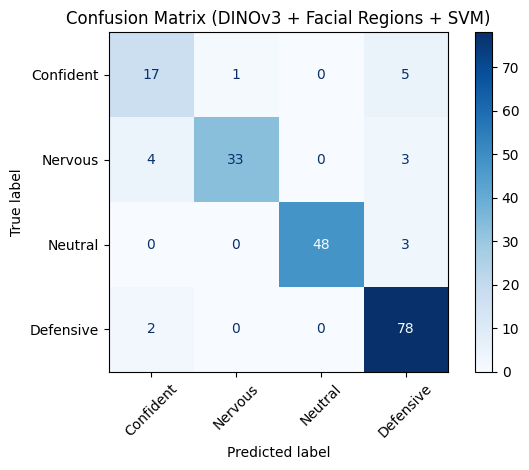

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# After your existing code...

# Print confusion matrix as text
print("\nConfusion Matrix:")
cm = confusion_matrix(test_labels, test_pred)
print(cm)

# Plot confusion matrix visually
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=new_classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (DINOv3 + Facial Regions + SVM)")
plt.tight_layout()
plt.show()


In [ ]:
import joblib
import os

os.makedirs('model_configuration', exist_ok=True)

# Save the new model with probability support
joblib.dump(grid.best_estimator_, 'model_configuration/best_svm_model_facial.pkl')

# Save DINO config
with open('model_configuration/dino_model_config_facial.txt', 'w') as f:
    f.write("facebook/dinov3-vits16plus-pretrain-lvd1689m")

# Save class names
with open('model_configuration/class_names_facial.txt', 'w') as f:
    for cls in new_classes:
        f.write(f"{cls}\n")
